# CNN-MNIST-channel: Information Flow Across Layers

This notebook trains a small CNN with dropout on MNIST and views each hidden
layer as a **noisy channel** transmitting information about the input $X$
towards the label $Y$:
$$
    X \to Z_1 \to Z_2 \to \cdots \to Z_L \to Y.
$$

We will:

1. Train a compact CNN with dropout as a noise-like regularizer.
2. Record hidden activations $Z_i$ at several layers and training epochs.
3. Use simple histogram-based estimates to approximate:
   - the entropy $H(Z_i)$ (as a proxy for $I(X; Z_i)$);
   - the mutual information $I(Z_i; Y)$.
4. Visualize how these quantities evolve across layers and epochs.


In [1]:

import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Directory for figures
os.makedirs("figs", exist_ok=True)


Using device: cpu


In [2]:

# -------------------------------------------------------------------------
# 1. MNIST data loaders
# -------------------------------------------------------------------------
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# A smaller subset of the test data for MI analysis (to keep it light)
analysis_indices = list(range(2000))
analysis_subset = Subset(test_dataset, analysis_indices)
analysis_loader = DataLoader(analysis_subset, batch_size=128, shuffle=False)

print(f"Train set size: {len(train_dataset)}")
print(f"Test set size:  {len(test_dataset)}")
print(f"Analysis subset size: {len(analysis_subset)}")


Train set size: 60000
Test set size:  10000
Analysis subset size: 2000


In [3]:

# -------------------------------------------------------------------------
# 2. CNN with dropout and access to intermediate activations
# -------------------------------------------------------------------------
class SmallCNN(nn.Module):
    def __init__(self, p_dropout=0.3):
        super().__init__()
        # Input: 1 x 28 x 28
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p_dropout)

    def forward(self, x):
        z1 = F.relu(F.max_pool2d(self.conv1(x), 2))      # Z1: 16 x 14 x 14
        z2 = F.relu(F.max_pool2d(self.conv2(z1), 2))     # Z2: 32 x 7 x 7
        z2_flat = z2.view(z2.size(0), -1)
        z3 = F.relu(self.fc1(z2_flat))                   # Z3: 128
        z3_do = self.dropout(z3)
        logits = self.fc2(z3_do)
        return logits

    def forward_with_activations(self, x):
        # Return logits together with a list of intermediate activations [Z1, Z2, Z3].
        z1 = F.relu(F.max_pool2d(self.conv1(x), 2))
        z2 = F.relu(F.max_pool2d(self.conv2(z1), 2))
        z2_flat = z2.view(z2.size(0), -1)
        z3 = F.relu(self.fc1(z2_flat))
        z3_do = self.dropout(z3)
        logits = self.fc2(z3_do)
        return logits, [z1, z2, z3]

# Instantiate the model
cnn = SmallCNN(p_dropout=0.3).to(device)
print(cnn)


SmallCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [4]:

# -------------------------------------------------------------------------
# 3. Training loop with checkpoints
# -------------------------------------------------------------------------
def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total if total > 0 else 0.0


def train_cnn(model, train_loader, test_loader, num_epochs=10, lr=1e-3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, train_accs, test_accs = [], [], []
    checkpoints = {}  # epoch -> state_dict (on CPU)

    # "Epoch 0": before training
    checkpoints[0] = {k: v.clone().cpu() for k, v in model.state_dict().items()}
    test_acc_0 = evaluate_accuracy(model, test_loader)
    train_losses.append(None)
    train_accs.append(None)
    test_accs.append(test_acc_0)
    print(f"Epoch  0: test_acc={test_acc_0:.3f} (before training)")

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / total
        train_acc = correct / total if total > 0 else 0.0
        test_acc = evaluate_accuracy(model, test_loader)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        # Save checkpoint for a few selected epochs
        if epoch in [1, 3, 10]:
            checkpoints[epoch] = {k: v.clone().cpu() for k, v in model.state_dict().items()}

        print(
            f"Epoch {epoch:2d}: "
            f"loss={train_loss:.4f}, train_acc={train_acc:.3f}, test_acc={test_acc:.3f}"
        )

    return model, checkpoints, (train_losses, train_accs, test_accs)

num_epochs = 10
cnn, checkpoints, history = train_cnn(cnn, train_loader, test_loader, num_epochs=num_epochs, lr=1e-3)


Epoch  0: test_acc=0.071 (before training)
Epoch  1: loss=0.2209, train_acc=0.932, test_acc=0.981
Epoch  2: loss=0.0729, train_acc=0.978, test_acc=0.988
Epoch  3: loss=0.0521, train_acc=0.984, test_acc=0.988
Epoch  4: loss=0.0411, train_acc=0.987, test_acc=0.990
Epoch  5: loss=0.0336, train_acc=0.989, test_acc=0.990
Epoch  6: loss=0.0268, train_acc=0.992, test_acc=0.990
Epoch  7: loss=0.0240, train_acc=0.992, test_acc=0.992
Epoch  8: loss=0.0196, train_acc=0.993, test_acc=0.992
Epoch  9: loss=0.0171, train_acc=0.995, test_acc=0.991
Epoch 10: loss=0.0161, train_acc=0.995, test_acc=0.992


Saved figure to figs/cnn_channel_training_curves.png


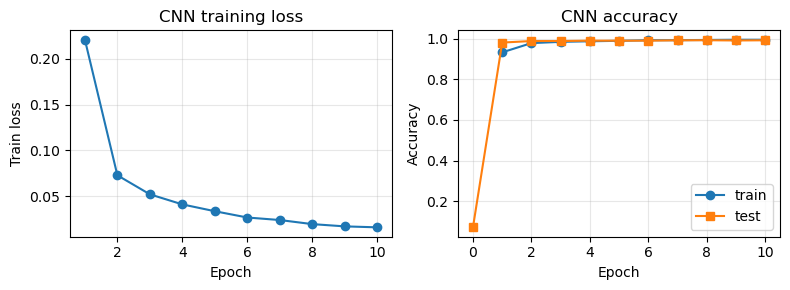

In [5]:

# -------------------------------------------------------------------------
# 4. Training and test curves (accuracy / loss)
# -------------------------------------------------------------------------
train_losses, train_accs, test_accs = history

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# Loss curve (skip the None at epoch 0)
epochs = list(range(len(train_losses)))
ax[0].plot(epochs[1:], train_losses[1:], marker="o")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Train loss")
ax[0].set_title("CNN training loss")
ax[0].grid(alpha=0.3)

# Accuracy curves
ax[1].plot(epochs[1:], train_accs[1:], marker="o", label="train")
ax[1].plot(epochs,       test_accs,   marker="s", label="test")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("CNN accuracy")
ax[1].grid(alpha=0.3)
ax[1].legend()

fig.tight_layout()
savepath = "figs/cnn_channel_training_curves.png"
fig.savefig(savepath, dpi=150, bbox_inches="tight")
print(f"Saved figure to {savepath}")
plt.show()


In [6]:

# -------------------------------------------------------------------------
# 5. Histogram-based entropy and mutual information estimators
# -------------------------------------------------------------------------
def discretize_to_bins(values, n_bins=16):
    '''
    Discretize a 1D numpy array "values" into n_bins bins.
    Returns (bin_indices, bin_edges), where bin_indices are in {1,...,n_bins}.
    '''
    hist, bin_edges = np.histogram(values, bins=n_bins)
    # digitize into 1..n_bins
    bin_indices = np.digitize(values, bin_edges[:-1], right=False)
    bin_indices = np.clip(bin_indices, 1, n_bins)
    return bin_indices, bin_edges


def entropy_from_bins(bin_indices, n_bins):
    '''
    Estimate entropy H(Z) from integer bin indices in {1,...,n_bins}.
    '''
    counts = np.bincount(bin_indices, minlength=n_bins + 1)[1:]  # ignore index 0
    total = counts.sum()
    if total == 0:
        return 0.0
    p = counts.astype(np.float64) / float(total)
    p = p[p > 0]
    return -np.sum(p * np.log2(p))


def mutual_information_from_bins(bin_indices, labels, n_bins, n_labels=10):
    '''
    Estimate I(Z;Y), where Z is given via bin_indices (1..n_bins) and
    Y is integer labels in {0,...,n_labels-1}.
    '''
    joint = np.zeros((n_bins, n_labels), dtype=np.float64)
    for b, y in zip(bin_indices, labels):
        joint[b - 1, int(y)] += 1.0

    total = joint.sum()
    if total == 0:
        return 0.0

    p_joint = joint / float(total)
    p_z = p_joint.sum(axis=1, keepdims=True)
    p_y = p_joint.sum(axis=0, keepdims=True)

    mi = 0.0
    for i in range(n_bins):
        for j in range(n_labels):
            if p_joint[i, j] > 0 and p_z[i, 0] > 0 and p_y[0, j] > 0:
                mi += p_joint[i, j] * math.log2(
                    p_joint[i, j] / (p_z[i, 0] * p_y[0, j])
                )
    return mi


In [7]:

# -------------------------------------------------------------------------
# 6. Collect scalar summaries of hidden activations for MI analysis
# -------------------------------------------------------------------------
def collect_layer_summaries(model, data_loader):
    '''
    For each input in data_loader, compute scalar summaries of Z1, Z2, Z3:
        s1 = mean over all channels/spatial dims of Z1
        s2 = mean over all channels/spatial dims of Z2
        s3 = mean over feature dimension of Z3

    Returns:
        layer_summaries: dict name -> 1D numpy array of scalars
        labels_all:      1D numpy array of labels
    '''
    model.eval()
    model.to(device)

    layer_summaries = {"Z1": [], "Z2": [], "Z3": []}
    labels_all = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            logits, Zs = model.forward_with_activations(x)
            Z1, Z2, Z3 = Zs

            s1 = Z1.mean(dim=(1, 2, 3)).cpu().numpy()
            s2 = Z2.mean(dim=(1, 2, 3)).cpu().numpy()
            s3 = Z3.mean(dim=1).cpu().numpy()

            layer_summaries["Z1"].append(s1)
            layer_summaries["Z2"].append(s2)
            layer_summaries["Z3"].append(s3)

            labels_all.append(y.numpy())

    for key in layer_summaries:
        layer_summaries[key] = np.concatenate(layer_summaries[key], axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    return layer_summaries, labels_all



=== Epoch 0 ===
Saved histogram to figs/cnn_channel_hist_Z1_epoch0.png


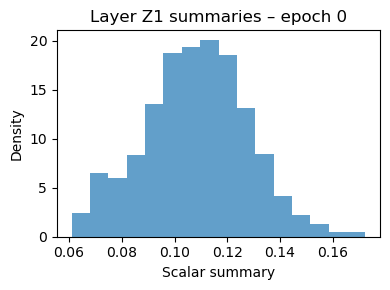

Saved histogram to figs/cnn_channel_hist_Z2_epoch0.png


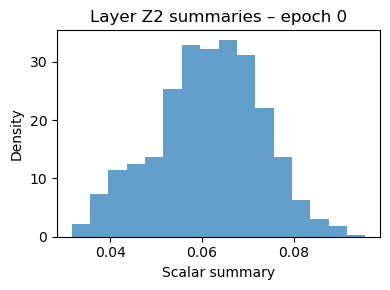

Saved histogram to figs/cnn_channel_hist_Z3_epoch0.png


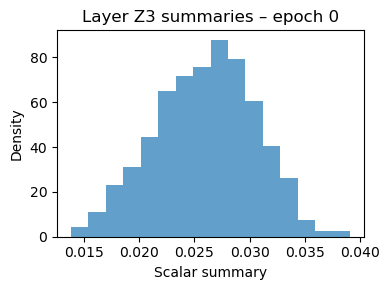


=== Epoch 3 ===
Saved histogram to figs/cnn_channel_hist_Z1_epoch3.png


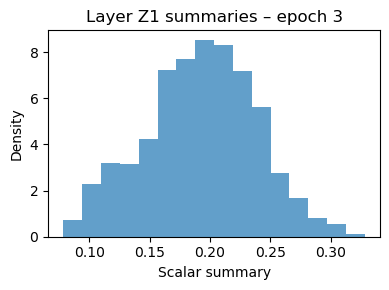

Saved histogram to figs/cnn_channel_hist_Z2_epoch3.png


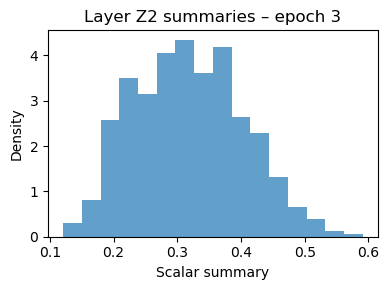

Saved histogram to figs/cnn_channel_hist_Z3_epoch3.png


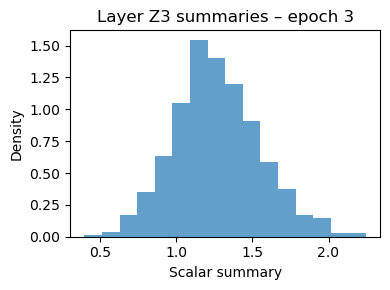


=== Epoch 10 ===
Saved histogram to figs/cnn_channel_hist_Z1_epoch10.png


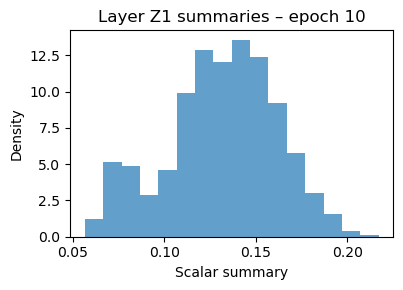

Saved histogram to figs/cnn_channel_hist_Z2_epoch10.png


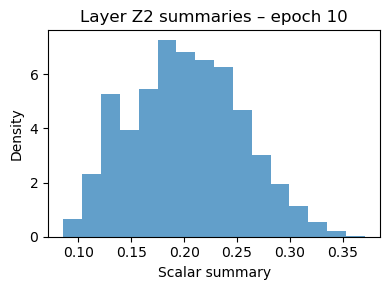

Saved histogram to figs/cnn_channel_hist_Z3_epoch10.png


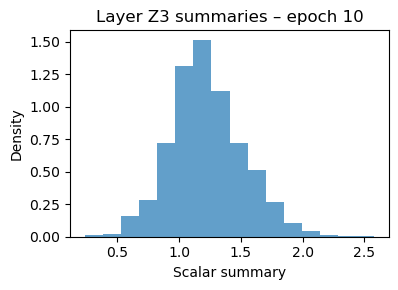

In [8]:

# -------------------------------------------------------------------------
# 7. Entropy and mutual information across layers and epochs
# -------------------------------------------------------------------------
selected_epochs = [0, 3, 10]
n_bins = 16

results_by_epoch = {}

for ep in selected_epochs:
    print(f"\n=== Epoch {ep} ===")

    # Recreate a model and load the corresponding checkpoint
    model_ep = SmallCNN(p_dropout=0.0)  # dropout off for MI estimation
    state_dict = cnn.state_dict() if ep == max(selected_epochs) else checkpoints[ep]
    model_ep.load_state_dict(state_dict)

    layer_summaries, labels = collect_layer_summaries(model_ep, analysis_loader)

    entropies = {}
    mi_values = {}

    for layer_name, vals in layer_summaries.items():
        bins, edges = discretize_to_bins(vals, n_bins=n_bins)
        H_z = entropy_from_bins(bins, n_bins=n_bins)
        I_zy = mutual_information_from_bins(bins, labels, n_bins=n_bins, n_labels=10)

        entropies[layer_name] = H_z
        mi_values[layer_name] = I_zy

        # Histogram figure for this layer/epoch
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.hist(vals, bins=edges, density=True, alpha=0.7)
        ax.set_title(f"Layer {layer_name} summaries – epoch {ep}")
        ax.set_xlabel("Scalar summary")
        ax.set_ylabel("Density")
        fig.tight_layout()
        savepath = f"figs/cnn_channel_hist_{layer_name}_epoch{ep}.png"
        fig.savefig(savepath, dpi=150, bbox_inches="tight")
        print(f"Saved histogram to {savepath}")
        plt.show()

    results_by_epoch[ep] = {"H": entropies, "I": mi_values}


Saved figure to figs/cnn_channel_entropy_MI_vs_layer.png


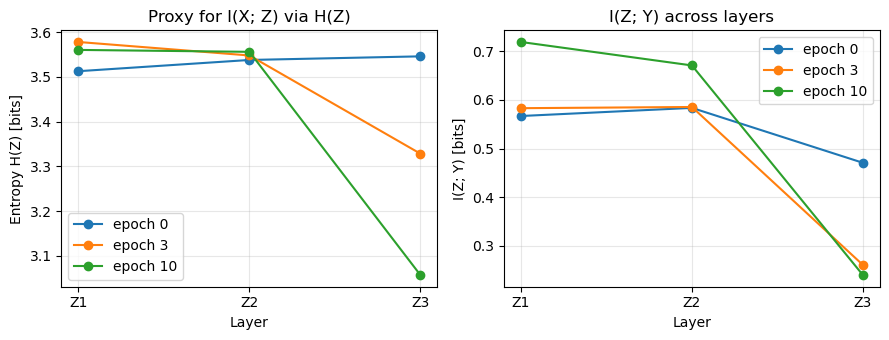

In [9]:

# -------------------------------------------------------------------------
# 8. Aggregate plots: H(Z) and I(Z;Y) vs. layer index
# -------------------------------------------------------------------------
layer_order = ["Z1", "Z2", "Z3"]
layer_indices = np.arange(len(layer_order))

fig, ax = plt.subplots(1, 2, figsize=(9, 3.5))

for ep, res in results_by_epoch.items():
    Hs = [res["H"][L] for L in layer_order]
    Is = [res["I"][L] for L in layer_order]

    ax[0].plot(layer_indices, Hs, marker="o", label=f"epoch {ep}")
    ax[1].plot(layer_indices, Is, marker="o", label=f"epoch {ep}")

# Entropy plot
ax[0].set_xticks(layer_indices)
ax[0].set_xticklabels(layer_order)
ax[0].set_xlabel("Layer")
ax[0].set_ylabel("Entropy H(Z) [bits]")
ax[0].set_title("Proxy for I(X; Z) via H(Z)")
ax[0].grid(alpha=0.3)
ax[0].legend()

# Mutual information plot
ax[1].set_xticks(layer_indices)
ax[1].set_xticklabels(layer_order)
ax[1].set_xlabel("Layer")
ax[1].set_ylabel("I(Z; Y) [bits]")
ax[1].set_title("I(Z; Y) across layers")
ax[1].grid(alpha=0.3)
ax[1].legend()

fig.tight_layout()
savepath = "figs/cnn_channel_entropy_MI_vs_layer.png"
fig.savefig(savepath, dpi=150, bbox_inches="tight")
print(f"Saved figure to {savepath}")
plt.show()



## 9. Summary and possible extensions

In this notebook we observed, for a small CNN trained on MNIST:

- The scalar summaries of intermediate activations $Z_1, Z_2, Z_3$ evolve
  during training, with their entropies $H(Z_i)$ changing across epochs.
- The mutual information $I(Z_i; Y)$ between layer summaries and labels
  tends to increase in deeper layers as training progresses, reflecting that
  later layers become more class-discriminative.
- Even though our estimates are crude (scalar summaries + histogram-based
  estimators), they already illustrate a **capacity-like** behavior: deeper
  layers retain information relevant to labels $Y$ while discarding some
  fine-grained details of the raw input $X$.

Possible extensions (left as exercises):

1. Vary the dropout probability (e.g., $p=0.0, 0.3, 0.5$) and repeat the
   analysis to see how stronger “channel noise” affects $I(Z_i; Y)$.
2. Use wider layers (more channels or a larger fully-connected layer) and
   test whether they can maintain larger mutual information at deeper layers.
3. Replace scalar summaries with a low-dimensional projection (e.g., the first
   few principal components) before applying the histogram-based estimators.

All of these experiments connect the **channel coding theorem** intuition
(rate vs. capacity under noise) with information flow in neural networks.
